In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

from colorama import Fore



from datetime import datetime, date 

from sklearn.model_selection import TimeSeriesSplit

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [13]:
csv_file_path = 'Aquifer_Petrignano.csv'
df = pd.read_csv(csv_file_path)
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
0,14/03/2006,NaN,-22.48,-22.18,NaN,NaN,NaN,NaN
1,15/03/2006,NaN,-22.38,-22.14,NaN,NaN,NaN,NaN
2,16/03/2006,NaN,-22.25,-22.04,NaN,NaN,NaN,NaN
3,17/03/2006,NaN,-22.38,-22.04,NaN,NaN,NaN,NaN
4,18/03/2006,NaN,-22.60,-22.04,NaN,NaN,NaN,NaN


In [14]:
df.isna().sum()

Date                                       0
Rainfall_Bastia_Umbra                   1024
Depth_to_Groundwater_P24                  55
Depth_to_Groundwater_P25                  39
Temperature_Bastia_Umbra                1024
Temperature_Petrignano                  1024
Volume_C10_Petrignano                    198
Hydrometry_Fiume_Chiascio_Petrignano    1024
dtype: int64

In [15]:
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1) 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4199 entries, 0 to 4198
Data columns (total 6 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  4199 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P25              4172 non-null   float64
 3   Temperature_Bastia_Umbra              4199 non-null   float64
 4   Volume_C10_Petrignano                 4198 non-null   float64
 5   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(5), object(1)
memory usage: 197.0+ KB


In [17]:
df2 = df.drop("Date",axis=1)
df2.corr(method ='pearson')

,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
Rainfall_Bastia_Umbra,1.000000,0.067708,-0.052813,0.136405,0.141373
Depth_to_Groundwater_P25,0.067708,1.000000,0.117417,0.360793,0.000276
Temperature_Bastia_Umbra,-0.052813,0.117417,1.000000,-0.069267,-0.434575
Volume_C10_Petrignano,0.136405,0.360793,-0.069267,1.000000,0.216617
Hydrometry_Fiume_Chiascio_Petrignano,0.141373,0.000276,-0.434575,0.216617,1.000000


In [18]:
df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_5564\1201631751.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_5564\1201631751.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_5564\1201631751.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
C:\Users\Usuario\AppData\Local\Temp\ipykernel_5564\1201631751.py:4: FutureWarning: Series.fillna with 'method

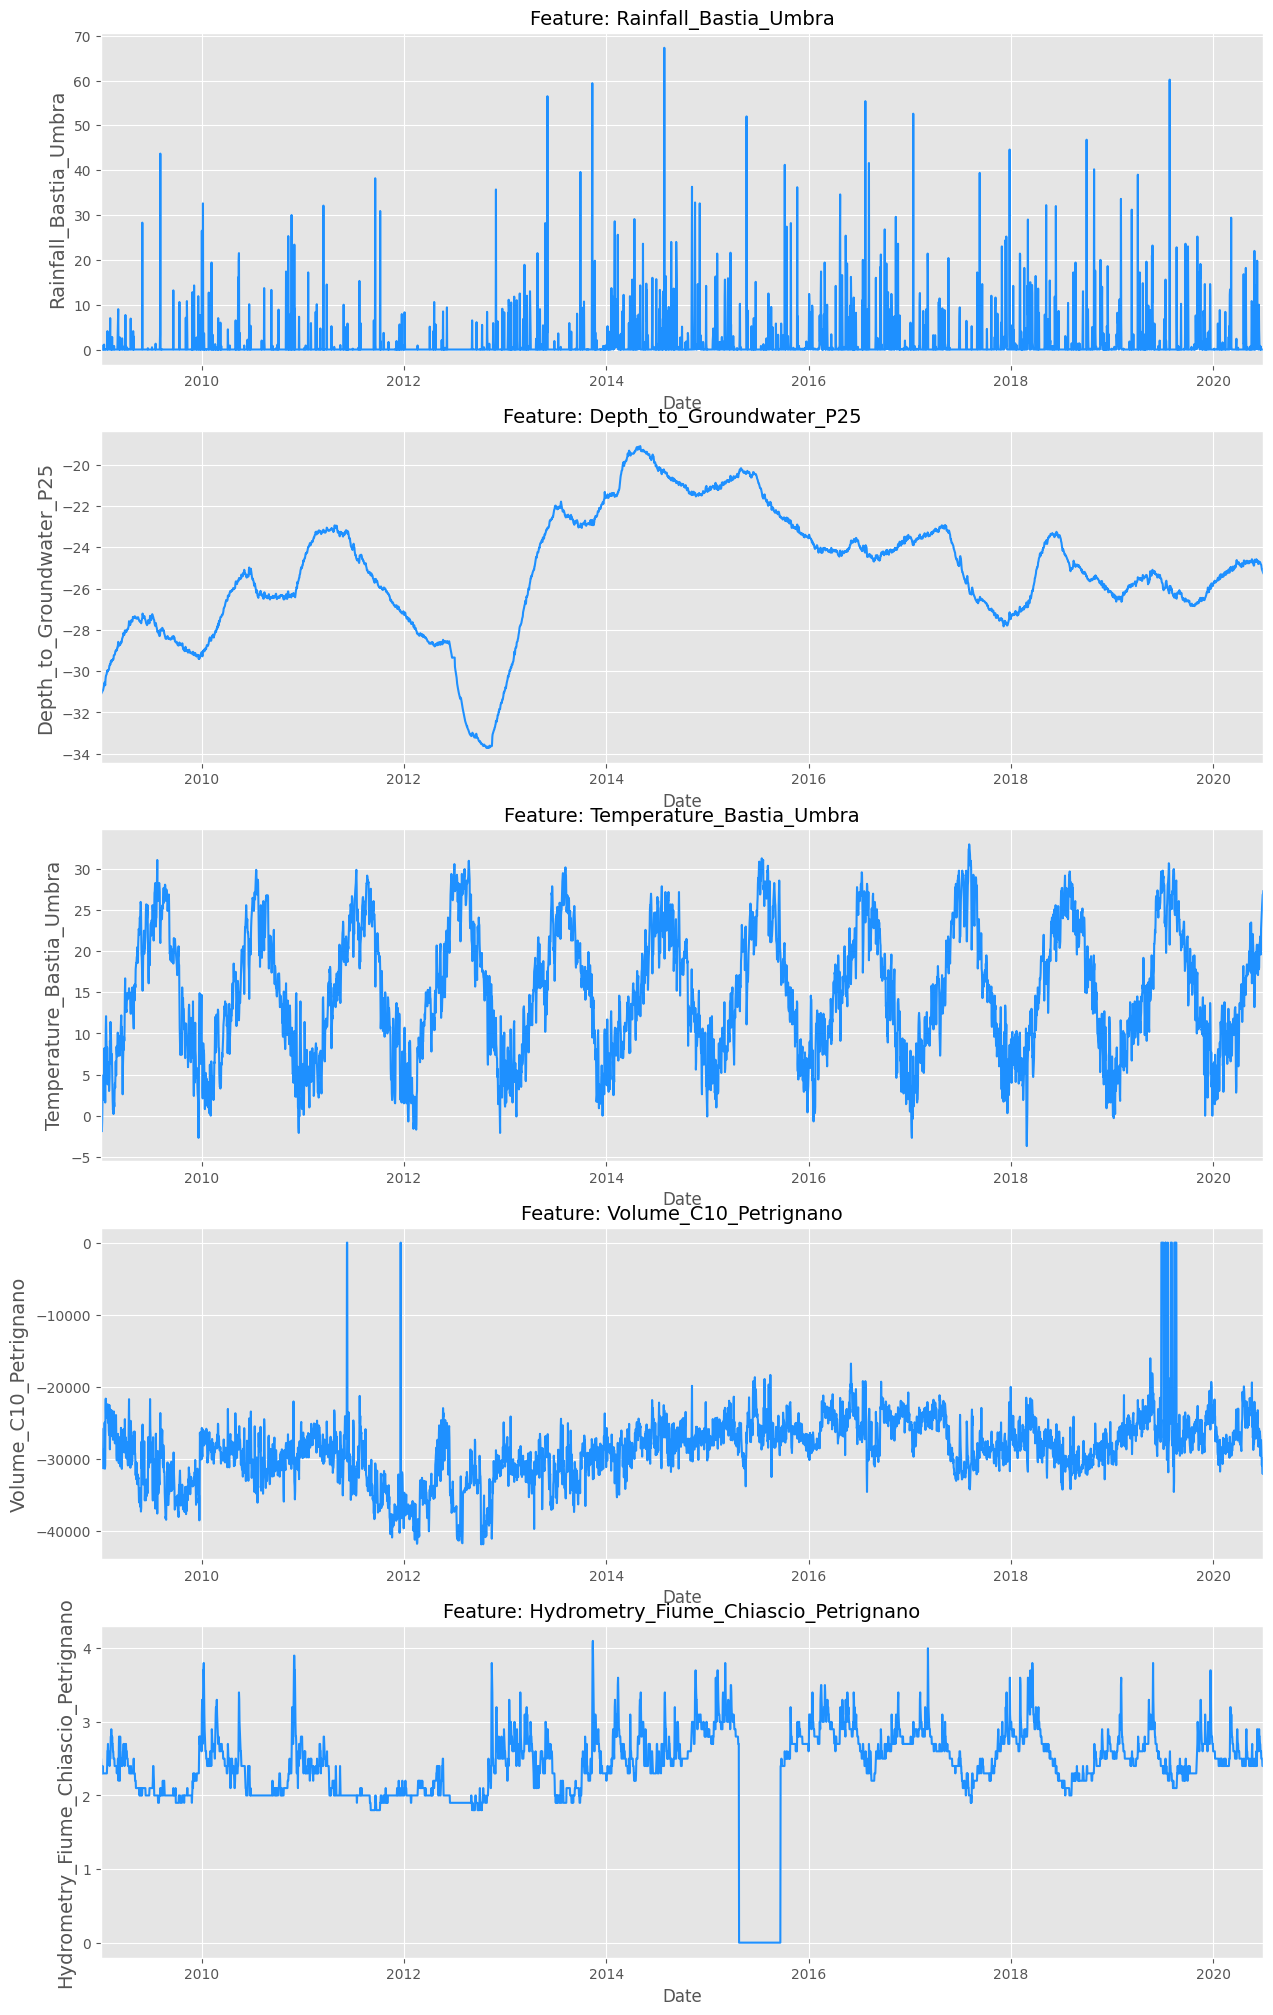

In [19]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

for i, column in enumerate(df.drop('Date', axis=1).columns):
    sns.lineplot(x=df['Date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
    ax[i].set_title('Feature: {}'.format(column), fontsize=14)
    ax[i].set_ylabel(ylabel=column, fontsize=14)
                      
    ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)]) 

In [20]:
df = df.fillna(df.mean())

In [21]:
downsample = df[['Date',
                 'Rainfall_Bastia_Umbra', 
                 'Depth_to_Groundwater_P25',
                 'Temperature_Bastia_Umbra', 
                 'Volume_C10_Petrignano',
                 'Hydrometry_Fiume_Chiascio_Petrignano'
                ]].resample('7D', on='Date').mean().reset_index(drop=False)

df = downsample.copy()

In [22]:
df.isna().sum()

Date                                    0
Rainfall_Bastia_Umbra                   0
Depth_to_Groundwater_P25                0
Temperature_Bastia_Umbra                0
Volume_C10_Petrignano                   0
Hydrometry_Fiume_Chiascio_Petrignano    0
dtype: int64

In [23]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['season'] = df['month'] % 12 // 3 + 1

In [24]:
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano,year,month,day,day_of_year,quarter,season
0,2009-01-01,0.000000,-31.048571,1.657143,-28164.918857,2.371429,2009,1,1,1,1,1
1,2009-01-08,0.285714,-30.784286,4.571429,-29755.789714,2.314286,2009,1,8,8,1,1
2,2009-01-15,0.028571,-30.420000,7.528571,-25463.190857,2.300000,2009,1,15,15,1,1
3,2009-01-22,0.585714,-30.018571,6.214286,-23854.422857,2.500000,2009,1,22,22,1,1
4,2009-01-29,1.414286,-29.790000,5.771429,-25210.532571,2.500000,2009,1,29,29,1,1


In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'Rainfall_Bastia_Umbra', 'Depth_to_Groundwater_P25', 'Temperature_Bastia_Umbra', 
    'Volume_C10_Petrignano', 'Hydrometry_Fiume_Chiascio_Petrignano'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

In [26]:
for column in core_columns:
    df[f'{column}_lag_4'] = df[f'{column}_seasonal'].shift(4)
    df[f'{column}_lag_8'] = df[f'{column}_seasonal'].shift(8)
    df[f'{column}_lag_12'] = df[f'{column}_seasonal'].shift(12)

In [27]:
df.head()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano,year,month,day,day_of_year,...,Depth_to_Groundwater_P25_lag_12,Temperature_Bastia_Umbra_lag_4,Temperature_Bastia_Umbra_lag_8,Temperature_Bastia_Umbra_lag_12,Volume_C10_Petrignano_lag_4,Volume_C10_Petrignano_lag_8,Volume_C10_Petrignano_lag_12,Hydrometry_Fiume_Chiascio_Petrignano_lag_4,Hydrometry_Fiume_Chiascio_Petrignano_lag_8,Hydrometry_Fiume_Chiascio_Petrignano_lag_12
0,2009-01-01,0.000000,-31.048571,1.657143,-28164.918857,2.371429,2009,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2009-01-08,0.285714,-30.784286,4.571429,-29755.789714,2.314286,2009,1,8,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2009-01-15,0.028571,-30.420000,7.528571,-25463.190857,2.300000,2009,1,15,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2009-01-22,0.585714,-30.018571,6.214286,-23854.422857,2.500000,2009,1,22,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2009-01-29,1.414286,-29.790000,5.771429,-25210.532571,2.500000,2009,1,29,29,...,NaN,-9.73992,NaN,NaN,1466.000089,NaN,NaN,0.295306,NaN,NaN


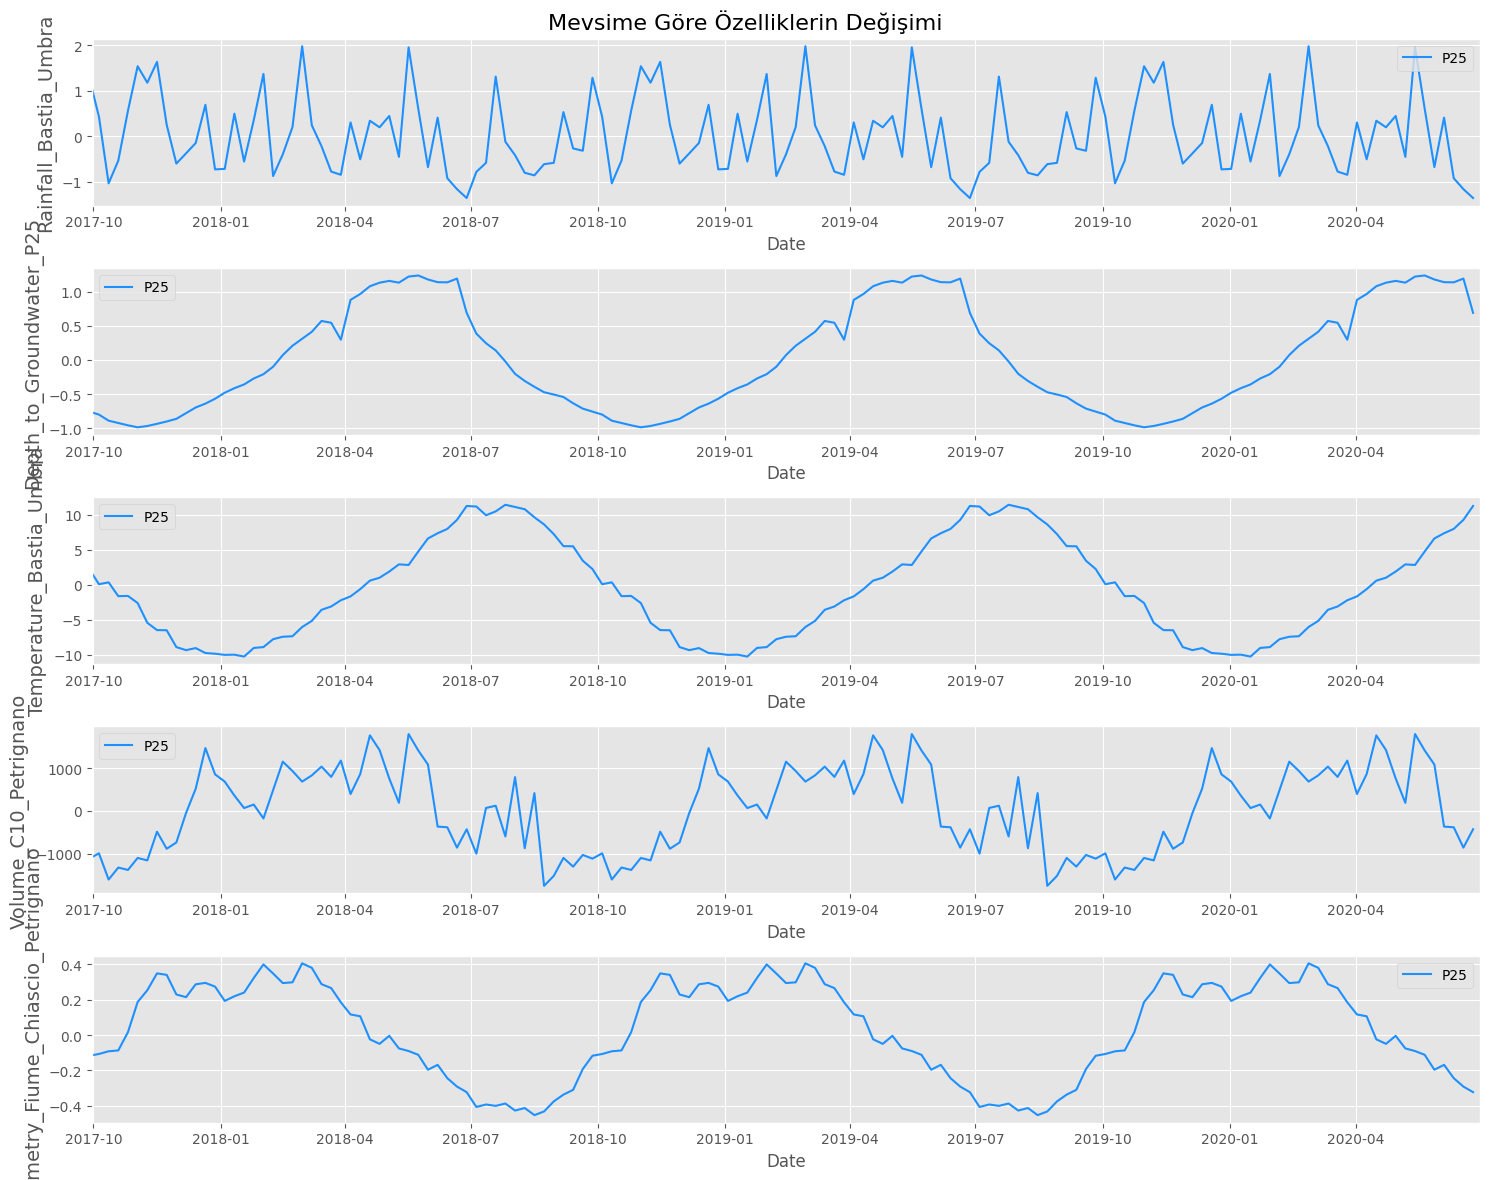

In [28]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Mevsime Göre Özelliklerin Değişimi', fontsize=16)

for i, column in enumerate(core_columns):
    sns.lineplot(x=df['Date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])
    
plt.tight_layout()
plt.show()

Model

In [29]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['Date', 'Depth_to_Groundwater_P25']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


In [30]:
N_SPLITS = 3

X = df['Date']
y = df['Depth_to_Groundwater_P25']

folds = TimeSeriesSplit(n_splits=N_SPLITS)

In [31]:
data = univariate_df.filter(['y'])

dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

In [32]:
look_back = 30

train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

450 90


In [33]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


450/450 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0135 - val_loss: 3.8507e-04
Epoch 2/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 3/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 4/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0026 - val_loss: 3.2892e-04
Epoch 5/5
450/450 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0017 - val_loss: 6.4821e-04


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │        81,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,625 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,403 (1.52 MB)

 Trainable params: 132,467 (517.45 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 264,936 (1.01 MB)

In [34]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
RMSE: 0.3684432999992079


MODEL 2

In [49]:
feature_columns = [
    'Rainfall_Bastia_Umbra',
    'Temperature_Bastia_Umbra',
    'Hydrometry_Fiume_Chiascio_Petrignano',
    'Volume_C10_Petrignano',
    'Rainfall_Bastia_Umbra_trend',
]
target_column = ['Depth_to_Groundwater_P25']

train_size = int(0.85 * len(df))

multivariate_df = df[['Date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5,6]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5,6]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,Rainfall_Bastia_Umbra,Temperature_Bastia_Umbra,Hydrometry_Fiume_Chiascio_Petrignano,Volume_C10_Petrignano,Rainfall_Bastia_Umbra_trend
0,2009-01-01,-31.048571,0.000000,1.657143,2.371429,-28164.918857,0.806294
1,2009-01-08,-30.784286,0.285714,4.571429,2.314286,-29755.789714,0.809093
2,2009-01-15,-30.420000,0.028571,7.528571,2.300000,-25463.190857,0.811892
3,2009-01-22,-30.018571,0.585714,6.214286,2.500000,-23854.422857,0.814691
4,2009-01-29,-29.790000,1.414286,5.771429,2.500000,-25210.532571,0.817490


In [51]:
from prophet import Prophet

model = Prophet()

model.add_regressor('Volume_C10_Petrignano')
model.add_regressor('Rainfall_Bastia_Umbra')
model.add_regressor('Temperature_Bastia_Umbra')
model.add_regressor('Hydrometry_Fiume_Chiascio_Petrignano')
model.add_regressor('Rainfall_Bastia_Umbra_trend')


model.fit(train)

y_pred = model.predict(x_valid)

score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

Importing plotly failed. Interactive plots will not work.
20:35:25 - cmdstanpy - INFO - Chain [1] start processing
20:35:26 - cmdstanpy - INFO - Chain [1] done processing


RMSE: 0.977281257979903


c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\Usuario\AppData\Local\Programs\Python\Python312\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


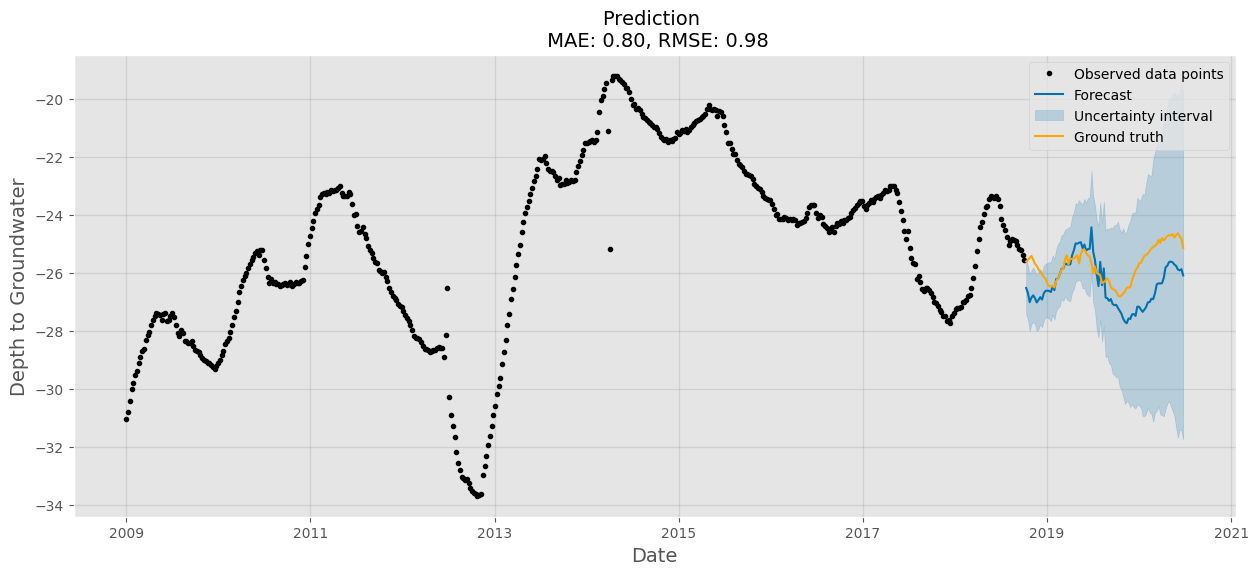

In [52]:
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth')

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

In [53]:
df2 = df.drop(["Date"],axis=1)
df2 = df2.dropna()

In [54]:
df2.corr()

'''
Rainfall_Bastia_Umbra_trend
Temperature_Bastia_Umbra_trend
Volume_C10_Petrignano_trend

'''

'\nRainfall_Bastia_Umbra_trend\nTemperature_Bastia_Umbra_trend\nVolume_C10_Petrignano_trend\n\n'